In [85]:
import cv2
import imutils
from skimage.filters import threshold_local
from scipy.spatial import distance as dist
import numpy as np
import random as rng
from matplotlib import pyplot as plt
from math import sqrt

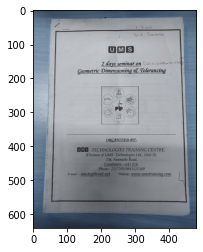

In [86]:
rng.seed(12345)

# read and show the input image
img_path = 'images/document-straight.jpeg'
input_img = cv2.imread(img_path)
plt.imshow(input_img)

In [87]:
def get_line_coefficients(p1: tuple, p2: tuple):
  x1, y1 = p1
  x2, y2 = p2

  a = y1 - y2
  b = x2 - x1
  c = x1*y2 - x2*y1

  return (a,b,c)


In [88]:
def get_intersection_points(coeff_1: tuple, coeff_2: tuple):
  a1, b1, c1 = coeff_1
  a2, b2, c2 = coeff_2

  x = 0 
  y = 0

  det = a1 * b2 - a2 * b1

  x_num = b1 * c2 - b2 * c1

  y_num = c1 * a2 - c2 * a1

  # lines are approximately parallel 
  if det > -0.5 and det < 0.5:
    return None
  

  if det != 0:
    x = x_num / det
    y = y_num / det
    return (x, y)
  
  return None


In [89]:
def distance_between_points(p1: tuple, p2: tuple):
  x1, y1 = p1
  x2, y2, = p2
  distance = sqrt((x2 - x1)**2 + (y2 - y1)**2)
  return distance

In [90]:
def are_similar_corners(c1: tuple, c2: tuple): 
  return True if distance_between_points(c1, c2) < 3 else False


In [91]:
def remove_similar_corners(all_corners):
  corners = []
  # get one corner
  for i in range(len(all_corners)): 
    # check with all other corners
    similar_corner = False
    for j in range(len(all_corners)): 
      # if we have checked all corners upto this one then break
      if i == j:
        break
      # if corner is similar to any of the previous corners then we do not add this corner
      if are_similar_corners(all_corners[i], all_corners[j]): 
        similar_corner = True
        break
    if not similar_corner:
      corners.append(all_corners[i])
      
  return corners

In [92]:
def get_all_possible_corners(coefficients, row_size, col_size): 
  all_corners = []

  # for every combination of coeffs get the intersection points
  for i in range(len(coefficients)):
    for j in range(i, len(coefficients)):
      if(i != j): 
      
        int_point = get_intersection_points(coefficients[i], coefficients[j])
        if int_point != None: 
          x, y = int_point
          # coords should be within the image boundaries
          if x > 0 and y > 0 and x < col_size and y < row_size:
            all_corners.append(int_point)
            
  return all_corners

In [93]:
def sort_contours(elem):
    return cv2.arcLength(elem, closed=True)
    
def get_corners(grayscale: cv2.Mat, output: cv2.Mat):
  convex_hull_mask = np.zeros((grayscale.shape[0], grayscale.shape[1], 3), dtype=np.uint8)


  convex_hull_mask_grayscale = cv2.cvtColor(convex_hull_mask, cv2.COLOR_BGR2GRAY)

  # Find contours
  contours, _ = cv2.findContours(grayscale, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  # get the largest contour by sorting the contours wrt arcLength
  contours = sorted(contours, key=sort_contours, reverse=True)[:1]

  # convex hull object
  hull_list = []
  hull = cv2.convexHull(contours[-1], True)
  hull_list.append(hull)

  cv2.drawContours(convex_hull_mask_grayscale, hull_list, -1, (255,0,0), 2, 8)

  cv2.imshow('Convex Hull Mask', convex_hull_mask_grayscale)
  cv2.waitKey(10)

  # # rho: The resolution parameter rho in pixels.
  # # theta: The resolution of the parameter \theta in radians.
  # # threshold: The minimum number of intersecting points to detecta line.

  lines = cv2.HoughLinesP(image = convex_hull_mask_grayscale, rho = 1, theta = np.pi / 180, minLineLength=200, maxLineGap=0, threshold=40)

  # draw all houghlines
  if lines is not None:
    for line in lines:
      l = line[0]
      cv2.line(output, (l[0], l[1]), (l[2], l[3]), (0,255,0), 2, cv2.LINE_AA )
  
  cv2.imshow('Lines', output) 
  # if at any point there are at least four lines then find the corners
    
  print("number of lines: ", len(lines))

  if len(lines) >= 4:
    coefficients = []
    for line in lines:
      l = line[0]
      coefficients.append(get_line_coefficients((l[0], l[1]), (l[2], l[3])))
  

    rows, cols = grayscale.shape

    # get all the corners from lines
    all_corners = get_all_possible_corners(coefficients, rows, cols)

    print("all corners found: ", len(all_corners), all_corners)

    # remove corners that are similar to one corner
    corners = remove_similar_corners(all_corners)

    print("number of corners: ", len(corners))
    
    return corners if len(corners) == 4 else None


In [94]:
def order_points(points: list):
	# initialize a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	pts = np.array(points)
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

In [95]:
def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	# maxWidth = max(int(widthA), int(widthB))
	maxWidth = 595

	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	# maxHeight = max(int(heightA), int(heightB))
	maxHeight = 842

	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped


In [96]:
# Convert image to gray and blur it
input_grey = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
input_grey = cv2.GaussianBlur(input_grey, (3,3), 0)
# ret, input_grey = cv2.threshold(input_grey, 130, 200, cv2.THRESH_BINARY)

cv2.imshow("BINARY", input_grey)

img_copy = input_img.copy()

edges = cv2.Canny(input_grey, 83, 300)

cv2.imshow('Canny', edges)
cv2.waitKey(10)

corners = get_corners(edges, input_img)

if corners is None:
  print("INVALID CORNERS")
else: 
  print("FINAL CORNERS: ", corners)
  # draw corner points on the image
  for x, y in corners:
      cv2.circle(input_img, (int(x), int(y)),3, (0, 0, 255), 4)

  cv2.imshow('Corners', input_img)
  cv2.waitKey(10)

  # perspective_transform(corners)
  warped_img = four_point_transform(img_copy, corners)
  cv2.imshow("warped img", warped_img)
  cv2.waitKey(10)

# give a black and white feel to the image
# T = threshold_local(warped_img, 11, offset = 10, method = "gaussian")
# warped = (warped_img > T).astype("uint8") * 255
# cv2.imshow("Scanned", imutils.resize(warped, height = 842))
# cv2.waitKey(0)
# cv2.destroyAllWindows()





number of lines:  9
all corners found:  20 [(61.923478260869565, 61.0504347826087), (54.303030303030305, 564.0), (54.31818181818182, 563.0), (54.28787878787879, 565.0), (434.9979127530787, 54.93446044667084), (435.3186568673724, 54.92920234643652), (64.02875475285171, 61.01592205323194), (60.19025576651499, 61.078848266122705), (451.21019108280257, 564.0), (451.1783439490446, 563.0), (451.2420382165605, 565.0), (452.0781893004115, 564.0), (56.73913043478261, 564.0), (52.97129186602871, 564.0), (452.04526748971193, 563.0), (452.1111111111111, 565.0), (56.7536231884058, 563.0), (52.985645933014354, 563.0), (56.72463768115942, 565.0), (52.95693779904306, 565.0)]
number of corners:  4
FINAL CORNERS:  [(61.923478260869565, 61.0504347826087), (54.303030303030305, 564.0), (434.9979127530787, 54.93446044667084), (451.21019108280257, 564.0)]
